## Neural network
For classification of sectors

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

In [4]:
df = pd.read_json('data_prep.json')
df.sector = pd.Categorical(df.sector)
df['code'] = df.sector.cat.codes
df.head()

,description,sector,code
0,Adara Acquisition Corp. does not have signific...,Financial Services,5
1,"AIM ImmunoTech Inc., an immuno-pharma company,...",Healthcare,6
2,"Ashford, Inc is an asset management firm. The ...",Financial Services,5
3,"The Arena Group Holdings, Inc., together with ...",Communication Services,1
4,"AMCON Distributing Company, together with its ...",Consumer Defensive,3


In [5]:
grouped_df = df.groupby('sector')
arr_list = [np.split(g, [int(.8 * len(g)), int(.9 * len(g))]) for i, g in grouped_df]

train = pd.concat([t[0] for t in arr_list])
val = pd.concat([v[2] for v in arr_list])
test = pd.concat([t[1] for t in arr_list])

In [6]:
for dataset in [train, val, test]:
    print(dataset.sector.value_counts(), '\n')

Financial Services        2007
Healthcare                1161
Industrials               1048
Technology                 911
Consumer Cyclical          819
Basic Materials            475
Energy & Utility           401
Real Estate                391
Consumer Defensive         328
Communication Services     322
Name: sector, dtype: int64 

Financial Services        251
Healthcare                146
Industrials               132
Technology                114
Consumer Cyclical         103
Basic Materials            60
Energy & Utility           51
Real Estate                49
Communication Services     41
Consumer Defensive         41
Name: sector, dtype: int64 

Financial Services        251
Healthcare                145
Industrials               131
Technology                114
Consumer Cyclical         102
Basic Materials            59
Energy & Utility           50
Real Estate                49
Consumer Defensive         41
Communication Services     40
Name: sector, dtype: int64 



In [11]:
def df_to_dataset(dataframe, shuffle=True, batch_size=64):
    df = dataframe.copy()
    code = df.pop('code')
    df = dataframe["description"]
    ds = tf.data.Dataset.from_tensor_slices((df, code))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    # ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [12]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [13]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [14]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(64, 50), dtype=float32, numpy=
array([[ 0.35128075, -0.14287934,  0.63384384, ..., -0.31920752,
        -0.05886671,  0.48105937],
       [ 0.5612409 , -0.00326681,  0.47185227, ..., -0.11872558,
        -0.50386167,  0.21904002],
       [ 0.25039256, -0.13239855,  0.21539998, ...,  0.05218336,
        -0.2984526 ,  0.2083318 ],
       ...,
       [ 0.6451863 ,  0.26165065,  0.29200828, ..., -0.2255368 ,
        -0.23700038,  0.9567872 ],
       [ 1.2960294 , -0.05297307,  0.27266848, ..., -0.34508452,
        -0.73566324,  0.5798842 ],
       [ 0.33030984, -0.18020801,  0.70723844, ..., -0.4334063 ,
         0.00472728, -0.00405066]], dtype=float32)>

In [15]:
model = tf.keras.Sequential([
    hub_layer,
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(10, activation='softmax')
])

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(patience=2, verbose=1, restore_best_weights=True)

In [17]:
model.evaluate(train_data)

123/123 [==============================] - 1s 2ms/step - loss: 2.9273 - accuracy: 0.0622


[2.9273314476013184, 0.06219000369310379]

In [18]:
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=10,
                    callbacks=[es])

Epoch 1/10
123/123 [==============================] - 53s 429ms/step - loss: 2.0960 - accuracy: 0.5439 - val_loss: 1.7170 - val_accuracy: 0.6073
Epoch 2/10
123/123 [==============================] - 51s 414ms/step - loss: 1.1244 - accuracy: 0.7917 - val_loss: 1.2585 - val_accuracy: 0.7034
Epoch 3/10
123/123 [==============================] - 50s 409ms/step - loss: 0.8003 - accuracy: 0.8716 - val_loss: 1.1557 - val_accuracy: 0.7419
Epoch 4/10
123/123 [==============================] - 51s 412ms/step - loss: 0.6403 - accuracy: 0.9135 - val_loss: 1.1054 - val_accuracy: 0.7227
Epoch 5/10
123/123 [==============================] - 50s 406ms/step - loss: 0.5350 - accuracy: 0.9442 - val_loss: 1.0201 - val_accuracy: 0.7591
Epoch 6/10
123/123 [==============================] - 50s 408ms/step - loss: 0.4598 - accuracy: 0.9643 - val_loss: 1.0089 - val_accuracy: 0.7480
Epoch 7/10
123/123 [==============================] - 50s 406ms/step - loss: 0.4044 - accuracy: 0.9798 - val_loss: 0.9761 - val_ac

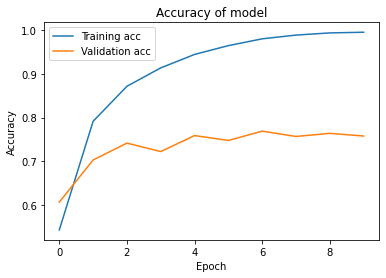

In [19]:
plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'], label="Validation acc")
plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

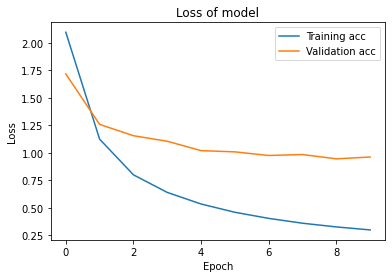

In [20]:
plt.plot(history.history['loss'], label="Training acc")
plt.plot(history.history['val_loss'], label="Validation acc")
plt.title("Loss of model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [21]:
model.evaluate(test_data)

16/16 [==============================] - 1s 59ms/step - loss: 0.8826 - accuracy: 0.7729


[0.8826205134391785, 0.7729124426841736]